In [ ]:
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop



import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Load the dataset
data = pd.read_csv('/content/drive/My Drive//teleCust1000t.csv')

# Inspect the first few rows
print(data.head())

   region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat  
0       2        1  
1       6        4  
2       2        3  
3       1        1  
4       4        3  


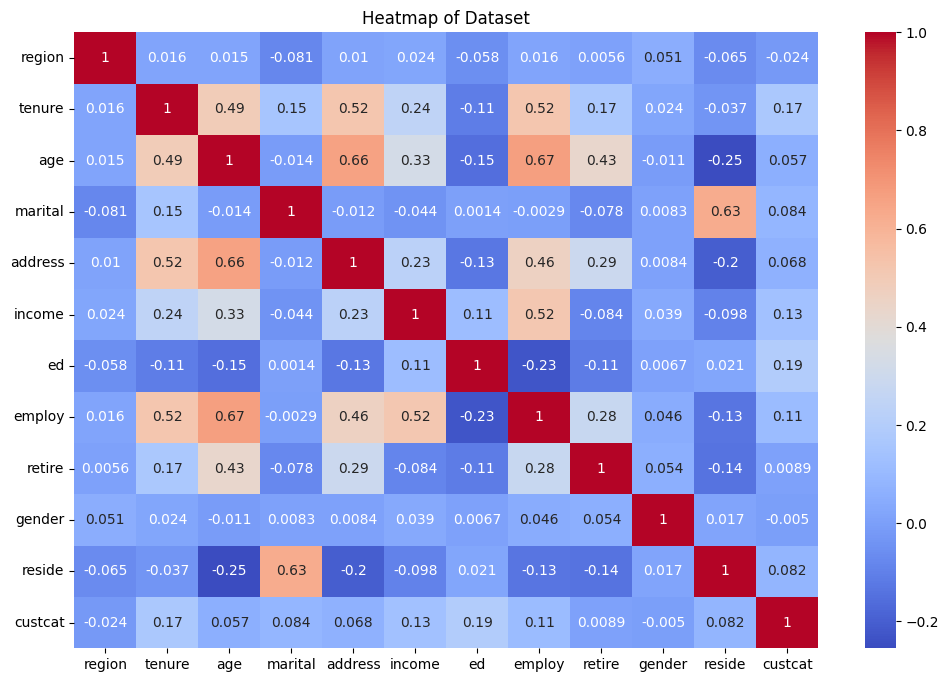

In [ ]:
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')  # Use correlation matrix for heatmap
plt.title('Heatmap of Dataset')
plt.show()

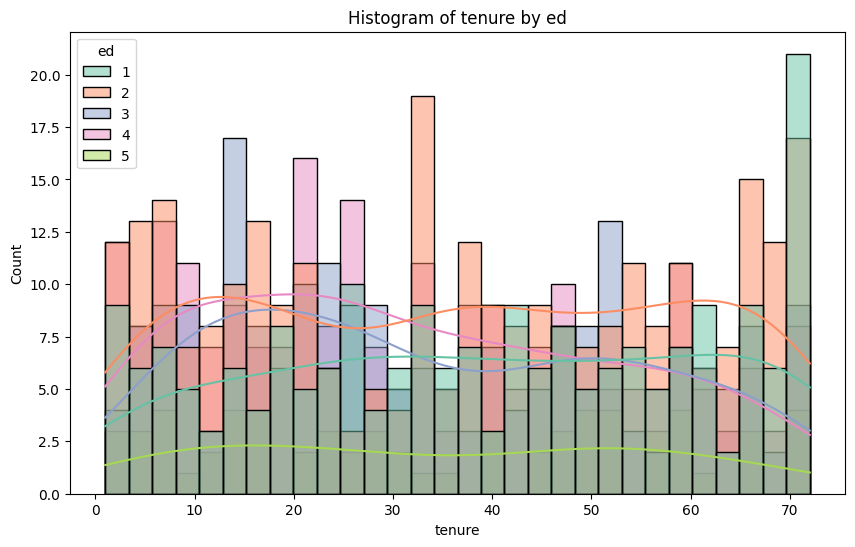

In [ ]:
feature1 = 'tenure'
feature2 = 'ed'
target = data['custcat']

plt.figure(figsize=(10, 6))  # Set figure size
sns.histplot(data=data, x=feature1, hue=feature2, kde=True, bins=30, palette='Set2')
plt.title(f'Histogram of {feature1} by {feature2}')
plt.xlabel(feature1)
plt.ylabel('Count')
plt.show()

In [ ]:
target = data['custcat']
features = data.drop(columns=['custcat'])

# Step 1: Split the dataset into training and temp datasets
train_data, temp_data, train_labels, temp_labels = train_test_split(
    features, target, test_size=0.3, random_state=42
)

# Split temp data into validation and test sets
validation_data, test_data, validation_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42
)

# Step 2: Normalize the features using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
train_data_scaled = scaler.fit_transform(train_data)

# Transform validation and test data with the same scaler
validation_data_scaled = scaler.transform(validation_data)
test_data_scaled = scaler.transform(test_data)




In [ ]:
# Check the range (min and max) of the scaled features
print(f"Min value in scaled train data: {np.min(train_data_scaled)}")
print(f"Max value in scaled train data: {np.max(train_data_scaled)}")

# Check the mean and standard deviation of the scaled train data
print(f"Mean value in scaled train data: {np.mean(train_data_scaled)}")
print(f"Standard deviation of scaled train data: {np.std(train_data_scaled)}")

Min value in scaled train data: 0.0
Max value in scaled train data: 1.0
Mean value in scaled train data: 0.3192609017240444
Standard deviation of scaled train data: 0.3562674854627224


In [ ]:
y_train = to_categorical(train_labels-1, num_classes=4)
y_val = to_categorical(validation_labels-1, num_classes=4)
y_test = to_categorical(test_labels-1, num_classes=4)


In [ ]:
def create_model(layers=1, neurons=32, optimizer='sgd', use_batchnorm=False, dropout_rate=0.0):
    model = Sequential()

    # Input layer and first hidden layer
    model.add(Dense(neurons, activation='relu', input_shape=(train_data_scaled.shape[1],)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Additional hidden layer if layers=2
    if layers == 2:
        model.add(Dense(neurons, activation='relu'))
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(4, activation='softmax'))


    # Compile the model with SGD optimizer
    if optimizer == 'sgd':
        opt = SGD(learning_rate=0.01)  # Using SGD optimizer
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # Use categorical_crossentropy for multi-class
    return model


In [ ]:
neurons_list = [10, 30, 70]
results = []

for neurons in neurons_list:
    print(f"\nTraining model with {neurons} neurons...")

    model1 = create_model(layers=1, neurons=neurons, use_batchnorm=True, dropout_rate=0.0, optimizer='sgd')
    model1.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=1)

    model2 = create_model(layers=2, neurons=neurons, use_batchnorm=True, dropout_rate=0.0, optimizer='sgd')
    model2.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled
    , y_val), epochs=10, batch_size=32, verbose=1)


    loss_1, accuracy_1 = model1.evaluate(test_data_scaled, y_test, verbose=0)
    print(f"Accuracy for model1 with {neurons} neurons: {accuracy_1:.4f}")

    loss_2, accuracy_2 = model2.evaluate(test_data_scaled, y_test, verbose=0)
    print(f"Accuracy for model2 with {neurons} neurons: {accuracy_2:.4f}")

    results.append({
        "Neurons": neurons,
        "Model 1 Accuracy": accuracy_1,
        "Model 2 Accuracy": accuracy_2
    })


print("\nComparison of results:")
for result in results:
    print(f"Model with {result['Neurons']} neurons - Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")


Training model with 10 neurons...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - accuracy: 0.3059 - loss: 1.6557 - val_accuracy: 0.3200 - val_loss: 1.3772
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3235 - loss: 1.5229 - val_accuracy: 0.3000 - val_loss: 1.3696
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3375 - loss: 1.4391 - val_accuracy: 0.3267 - val_loss: 1.3636
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3662 - loss: 1.3762 - val_accuracy: 0.3000 - val_loss: 1.3588
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3658 - loss: 1.3257 - val_accuracy: 0.3133 - val_loss: 1.3528
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4030 - loss: 1.3012 - val_accuracy: 0.3200 - val_loss: 1.3467
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3535 - loss: 1.3213 - val_accuracy: 0.3067 - val_loss: 1.3411
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4128 - loss: 1.2553 - val_accuracy: 0.3467 - val_loss: 1.3345
E

In [ ]:
# Loop to train the models
for dropout_rate in dropout_rates:
    for use_batchnorm in use_batchnorm_options:
        batchnorm_text = "with BatchNormalization" if use_batchnorm else "without BatchNormalization"
        dropout_text = "with Dropout" if dropout_rate > 0.0 else "without Dropout"

        print(f"\nTraining Model 1: 1 hidden layer, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate})...")
        model_1 = create_model(layers=1, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)

        # Train Model 1
        model_1.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=1)

        print(f"\nTraining Model 2: 2 hidden layers, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate})...")
        model_2 = create_model(layers=2, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)

        # Train Model 2
        model_2.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=1)

        # Evaluate Model 1
        print(f"\nEvaluating Model 1 on test set {batchnorm_text} and {dropout_text}...")
        loss_1, accuracy_1 = model_1.evaluate(test_data_scaled, y_test, verbose=0)
        print(f"Model 1 Accuracy: {accuracy_1:.4f}")

        # Evaluate Model 2
        print(f"\nEvaluating Model 2 on test set {batchnorm_text} and {dropout_text}...")
        loss_2, accuracy_2 = model_2.evaluate(test_data_scaled, y_test, verbose=0)
        print(f"Model 2 Accuracy: {accuracy_2:.4f}")

        # Store the results for comparison
        results.append({
            "Model 1 Accuracy": accuracy_1,
            "Model 2 Accuracy": accuracy_2,
            "Dropout Rate": dropout_rate,
            "BatchNorm": batchnorm_text
        })

# Print comparison results
print("\nComparison of Results:")
for result in results:
    print(f"Dropout Rate: {result['Dropout Rate']}, BatchNorm: {result['BatchNorm']}, Model 1 Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")


Training Model 1: 1 hidden layer, 64 neurons, with BatchNormalization and without Dropout (Dropout rate 0.0)...
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3301 - loss: 1.5676 - val_accuracy: 0.2867 - val_loss: 1.3828
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3427 - loss: 1.3854 - val_accuracy: 0.3133 - val_loss: 1.3755
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3680 - loss: 1.3004 - val_accuracy: 0.3133 - val_loss: 1.3691
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4023 - loss: 1.2835 - val_accuracy: 0.3667 - val_loss: 1.3638
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4033 - loss: 1.2437 - val_accuracy: 0.3400 - val_loss: 1.3564
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3992 - loss: 1.2280 - val_accuracy: 0.3600 - val_loss: 1.3489
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4257 - loss: 1.2087 - val_accuracy: 0.3733 - val_loss: 1.3399
Epoc

In [ ]:

# Function to create a model without L2-Regularization
def create_model(layers=1, neurons=32, optimizer='adam', use_batchnorm=False, dropout_rate=0.0):
    model = Sequential()

    # Input layer and first hidden layer without L2-Regularization
    model.add(Dense(neurons, activation='relu', input_shape=(train_data_scaled.shape[1],)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Additional hidden layer if layers=2
    if layers == 2:
        model.add(Dense(neurons, activation='relu'))  # No L2 Regularization
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    # Output layer for multiclass classification
    model.add(Dense(4, activation='sigmoid'))  # 4 output neurons for 4 classes

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters to evaluate
dropout_rates = [0.0, 0.3]
use_batchnorm_options = [True, False]  # Both options for BatchNormalization

results = []  # To store results for comparison

# Train and evaluate models with both Adam and RMSprop optimizers
for optimizer in ['adam', 'rmsprop']:
    for dropout_rate in dropout_rates:
        for use_batchnorm in use_batchnorm_options:
            batchnorm_text = "with BatchNormalization" if use_batchnorm else "without BatchNormalization"
            dropout_text = "with Dropout" if dropout_rate > 0.0 else "without Dropout"

            print(f"\nTraining Model 1: 1 hidden layer, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate}) with {optimizer} optimizer...")
            model_1 = create_model(layers=1, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer)
            model_1.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=1)

            print(f"\nTraining Model 2: 2 hidden layers, 64 neurons, {batchnorm_text} and {dropout_text} (Dropout rate {dropout_rate}) with {optimizer} optimizer...")
            model_2 = create_model(layers=2, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer)
            model_2.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=1)

            # Evaluate Model 1
            print(f"\nEvaluating Model 1 on test set {batchnorm_text} and {dropout_text} with {optimizer} optimizer...")
            loss_1, accuracy_1 = model_1.evaluate(test_data_scaled, y_test, verbose=0)
            print(f"Model 1 Accuracy: {accuracy_1:.4f}")

            # Evaluate Model 2
            print(f"\nEvaluating Model 2 on test set {batchnorm_text} and {dropout_text} with {optimizer} optimizer...")
            loss_2, accuracy_2 = model_2.evaluate(test_data_scaled, y_test, verbose=0)
            print(f"Model 2 Accuracy: {accuracy_2:.4f}")

            # Store the results for comparison
            results.append({
                "Model 1 Accuracy": accuracy_1,
                "Model 2 Accuracy": accuracy_2,
                "Dropout Rate": dropout_rate,
                "BatchNorm": batchnorm_text,
                "Optimizer": optimizer
            })

# Print comparison results
print("\nComparison of Results:")
for result in results:
    print(f"Optimizer: {result['Optimizer']}, Dropout Rate: {result['Dropout Rate']}, BatchNorm: {result['BatchNorm']}, Model 1 Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")



Training Model 1: 1 hidden layer, 64 neurons, with BatchNormalization and without Dropout (Dropout rate 0.0) with adam optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2745 - loss: 1.6423 - val_accuracy: 0.2867 - val_loss: 1.3652
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3396 - loss: 1.4310 - val_accuracy: 0.3400 - val_loss: 1.3586
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3875 - loss: 1.2938 - val_accuracy: 0.3333 - val_loss: 1.3543
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4073 - loss: 1.2319 - val_accuracy: 0.3867 - val_loss: 1.3452
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4121 - loss: 1.2263 - val_accuracy: 0.3867 - val_loss: 1.3366
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4356 - loss: 1.2161 - val_accuracy: 0.4000 - val_loss: 1.3306
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4417 - loss: 1.1891 - val_accuracy: 0.3867 - val_loss: 1.3232
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4152 - loss: 1.2176 - val_accuracy: 0.3600 - val_loss

In [ ]:
def create_model(layers=1, neurons=32, optimizer='adam', use_batchnorm=False, dropout_rate=0.0, l2_reg=0.0001):
    model = Sequential()

    # Input layer and first hidden layer
    model.add(Dense(neurons, activation='relu',
                    input_shape=(train_data_scaled.shape[1],),
                    kernel_regularizer=l2(l2_reg)))
    if use_batchnorm:
        model.add(BatchNormalization())
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))

    # Additional hidden layer if layers=2
    if layers == 2:
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=l2(l2_reg)))
        if use_batchnorm:
            model.add(BatchNormalization())
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    # Output layer for multiclass classification
    model.add(Dense(4, activation='softmax'))

    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters to evaluate
dropout_rates = [0.0, 0.3]
use_batchnorm_options = [True, False]  # Both options for BatchNormalization

results = []  # To store results for comparison

# Train and evaluate models with L2-Regularization (0.0001) and different settings
for optimizer in ['adam', 'rmsprop']:
    for dropout_rate in dropout_rates:
        for use_batchnorm in use_batchnorm_options:
            batchnorm_text = "with BatchNormalization" if use_batchnorm else "without BatchNormalization"
            dropout_text = "with Dropout" if dropout_rate > 0.0 else "without Dropout"

            print(f"\nTraining Model 1: 1 hidden layer, 64 neurons, {batchnorm_text}, {dropout_text} (Dropout rate {dropout_rate}), L2=0.0001, {optimizer} optimizer...")
            model_1 = create_model(layers=1, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer, l2_reg=0.0001)
            model_1.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=1)

            print(f"\nTraining Model 2: 2 hidden layers, 64 neurons, {batchnorm_text}, {dropout_text} (Dropout rate {dropout_rate}), L2=0.0001, {optimizer} optimizer...")
            model_2 = create_model(layers=2, neurons=64, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer=optimizer, l2_reg=0.0001)
            model_2.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=1)

            # Evaluate Model 1
            print(f"\nEvaluating Model 1 on test set {batchnorm_text}, {dropout_text}, L2=0.0001, {optimizer} optimizer...")
            loss_1, accuracy_1 = model_1.evaluate(test_data_scaled, y_test, verbose=0)
            print(f"Model 1 Accuracy: {accuracy_1:.4f}")

            # Evaluate Model 2
            print(f"\nEvaluating Model 2 on test set {batchnorm_text}, {dropout_text}, L2=0.0001, {optimizer} optimizer...")
            loss_2, accuracy_2 = model_2.evaluate(test_data_scaled, y_test, verbose=0)
            print(f"Model 2 Accuracy: {accuracy_2:.4f}")

            # Store the results for comparison
            results.append({
                "Model 1 Accuracy": accuracy_1,
                "Model 2 Accuracy": accuracy_2,
                "Dropout Rate": dropout_rate,
                "BatchNorm": batchnorm_text,
                "Optimizer": optimizer,
                "L2 Regularization": 0.0001
            })

# Print comparison results
print("\nComparison of Results:")
for result in results:
    print(f"Optimizer: {result['Optimizer']}, Dropout Rate: {result['Dropout Rate']}, BatchNorm: {result['BatchNorm']}, L2 Regularization: {result['L2 Regularization']}, Model 1 Accuracy: {result['Model 1 Accuracy']:.4f}, Model 2 Accuracy: {result['Model 2 Accuracy']:.4f}")


Training Model 1: 1 hidden layer, 64 neurons, with BatchNormalization, without Dropout (Dropout rate 0.0), L2=0.0001, adam optimizer...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2682 - loss: 1.7029 - val_accuracy: 0.3000 - val_loss: 1.3814
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3365 - loss: 1.4125 - val_accuracy: 0.2600 - val_loss: 1.3765
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3904 - loss: 1.3255 - val_accuracy: 0.2733 - val_loss: 1.3696
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4112 - loss: 1.2842 - val_accuracy: 0.3000 - val_loss: 1.3620
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4281 - loss: 1.2418 - val_accuracy: 0.3267 - val_loss: 1.3523
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4737 - loss: 1.1995 - val_accuracy: 0.3267 - val_loss: 1.3499
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4459 - loss: 1.2183 - val_accuracy: 0.3333 - val_loss: 1.3450
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4329 - loss: 1.2199 - val_accuracy: 0.3667 - val_loss: 1.3360
Ep

In [ ]:
# Assuming y_test has 150 samples
random_indices = np.random.choice(y_test.shape[0], size=10, replace=False)
X_test_sample = train_data_scaled[random_indices]
y_test_sample = y_test[random_indices]

results = []


optimizers = ['adam', 'rmsprop']
dropout_rates = [0.0, 0.3]
use_batchnorm_options = [True, False]


for optimizer in optimizers:
    for dropout_rate in dropout_rates:
        for use_batchnorm in use_batchnorm_options:
            batchnorm_text = "with BatchNormalization" if use_batchnorm else "without BatchNormalization"
            dropout_text = "with Dropout" if dropout_rate > 0.0 else "without Dropout"


            model = create_model(layers=2, neurons=64, optimizer=optimizer,
                                 use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)

            model.fit(train_data_scaled, y_train, validation_data=(validation_data_scaled, y_val), epochs=10, batch_size=32, verbose=0)


            predictions = model.predict(X_test_sample)
            predicted_classes = np.argmax(predictions, axis=1)
            actual_classes = np.argmax(y_test_sample, axis=1)


            print(f"\nModel: {optimizer} optimizer, Dropout Rate: {dropout_rate}, BatchNorm: {batchnorm_text}")
            for i in range(10):
                print(f"Sample {i + 1}:")
                print(f"  - Actual class: {actual_classes[i]}")
                print(f"  - Predicted class: {predicted_classes[i]}")
                print("-" * 40)


            loss, accuracy = model.evaluate(test_data_scaled, y_test, verbose=0)
            print(f"Model Accuracy on Test Data: {accuracy:.4f}")


            results.append({
                "Optimizer": optimizer,
                "Dropout Rate": dropout_rate,
                "BatchNorm": batchnorm_text,
                "Accuracy": accuracy
            })


print("\nComparison of Results:")
for result in results:
    print(f"Optimizer: {result['Optimizer']}, Dropout Rate: {result['Dropout Rate']}, BatchNorm: {result['BatchNorm']}, Accuracy: {result['Accuracy']:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Model: adam optimizer, Dropout Rate: 0.0, BatchNorm: with BatchNormalization
Sample 1:
  - Actual class: 2
  - Predicted class: 1
----------------------------------------
Sample 2:
  - Actual class: 0
  - Predicted class: 1
----------------------------------------
Sample 3:
  - Actual class: 2
  - Predicted class: 1
----------------------------------------
Sample 4:
  - Actual class: 0
  - Predicted class: 1
----------------------------------------
Sample 5:
  - Actual class: 3
  - Predicted class: 1
----------------------------------------
Sample 6:
  - Actual class: 2
  - Predicted class: 1
----------------------------------------
Sample 7:
  - Actual class: 1
  - Predicted class: 1
----------------------------------------
Sample 8:
  - Actual class: 2
  - Predicted class: 1
----------------------------------------
Sample 9:
  - Actual class: 3
  - Predicted class: 1
----------------------------------------
Sample 10:
  - Actual class: 3
  - Pre

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

Model: adam optimizer, Dropout Rate: 0.3, BatchNorm: without BatchNormalization
Sample 1:
  - Actual class: 2
  - Predicted class: 1
----------------------------------------
Sample 2:
  - Actual class: 0
  - Predicted class: 2
----------------------------------------
Sample 3:
  - Actual class: 2
  - Predicted class: 2
----------------------------------------
Sample 4:
  - Actual class: 0
  - Predicted class: 0
----------------------------------------
Sample 5:
  - Actual class: 3
  - Predicted class: 2
----------------------------------------
Sample 6:
  - Actual class: 2
  - Predicted class: 0
----------------------------------------
Sample 7:
  - Actual class: 1
  - Predicted class: 2
----------------------------------------
Sample 8:
  - Actual class: 2
  - Predicted class: 3
----------------------------------------
Sample 9:
  - Actual class: 3
  - Predicted class: 1
----------------------------------------
Sample 10:
  - Actual class: 3
  -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

Model: rmsprop optimizer, Dropout Rate: 0.0, BatchNorm: with BatchNormalization
Sample 1:
  - Actual class: 2
  - Predicted class: 3
----------------------------------------
Sample 2:
  - Actual class: 0
  - Predicted class: 2
----------------------------------------
Sample 3:
  - Actual class: 2
  - Predicted class: 3
----------------------------------------
Sample 4:
  - Actual class: 0
  - Predicted class: 3
----------------------------------------
Sample 5:
  - Actual class: 3
  - Predicted class: 2
----------------------------------------
Sample 6:
  - Actual class: 2
  - Predicted class: 3
----------------------------------------
Sample 7:
  - Actual class: 1
  - Predicted class: 2
----------------------------------------
Sample 8:
  - Actual class: 2
  - Predicted class: 3
----------------------------------------
Sample 9:
  - Actual class: 3
  - Predicted class: 1
----------------------------------------
Sample 10:
  - Actual class: 3
  - 

In [ ]:
predictions_model_1 = model_1.predict(test_data_scaled)
predictions_model_2 = model_2.predict(test_data_scaled)

predicted_classes_model_1 = np.argmax(predictions_model_1, axis=1)
predicted_classes_model_2 = np.argmax(predictions_model_2, axis=1)


final_predictions = []
for i in range(len(predicted_classes_model_1)):

    final_predictions.append(np.bincount([predicted_classes_model_1[i], predicted_classes_model_2[i]]).argmax())


actual_classes = np.argmax(y_test, axis=1)


accuracy_combined = accuracy_score(actual_classes, final_predictions)
print(f"\nCombined Model Accuracy: {accuracy_combined:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Combined Model Accuracy: 0.3600
